In [1]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
from statsmodels.stats.stattools import durbin_watson
from pathlib import Path

### Data Augmentation

The aim of this project is to develop a machine learning model to predict real estate prices. To enhance the model's prediction accuracy, factors influencing property value are categorized into two main groups: **property characteristics** and **locational attributes** (or neighborhood characteristics).

* 1. Property Characteristics

**Property characteristics** refer to the structural attributes of a property, such as size, year of construction, amenities, and property type. These factors are often used to predict property values, and the dataset *immoweb_database* includes these features for 34,970 observations. 

This database is the result of the __[scrapping challenge](https://github.com/MaximSchuermans/immo-eliza/blob/main/data/cleaned_data.csv)__, which involved scraping data from the Belgian real estate website [Immoweb](https://www.immoweb.be/). The database was further enhanced by a second round of data scraping using the same scraper.

* 2. Neighborhood Characteristics

**Neighborhood characteristics** refer to factors related to the location of the property, such as social demographics, proximity to public services (e.g., schools, hospitals, public transport), and environmental aspects (e.g., crime rates, air quality). These factors significantly influence property values.

In this dataset, the only neighborhood-related feature currently available is the **postal code**. To enhance this, the following features will be added:

2.1 Municipality

To add more geo-spatial data, the dataset is being merged with the __[*postal_codes_belgium*](https://data.gov.be/en/datasets/httpswwwodwbbeexploredatasetpostal-codes-belgium)__ dataset, which contains Belgian postal codes and corresponding municipalities.

2.2 Prosperity Index

The **Prosperity Index** will be added to represent the relative average income of a municipality compared to the national average. This data is available from the __[fisc2022_c_NL](https://statbel.fgov.be/en/themes/households/taxable-income#figures)__ dataset, which contains fiscal statistics for 2022.

2.3 Total Population and Population Density

Data from the __[Pop_density_en](https://statbel.fgov.be/en/themes/population/structure-population/population-density#figures)__ dataset will be used to include the total population and population density (population per square kilometer) for each municipality, based on data from January 2024.

2.4 Crime Rate

The **crime rate** will be calculated using data from the Federal Police __[criminal_figures_statistics_table](https://www.politie.be/statistieken/nl/criminaliteit/criminele-figuren/tabel?view=undefined&year=2023)__ database. This data contains crime statistics per municipality for 2023. The crime rate will be calculated per 1,000 inhabitants based on the total population data mentioned above.

2.5 Median Price of Properties by Municipality

The **median price of properties** per municipality will be derived from the __[Sales of real estate (N) per quarter per municipality 2010-2024](https://statbel.fgov.be/en/themes/housing/house-price-index#documents)__ dataset. The median price for each municipality will be calculated using data from 2023 and the first two trimesters of 2024.

2.6 NIS Code per Municipality

Some datasets identify municipalities using their **NIS code**, a numeric code for statistical purposes in Belgium. This code will also be included as part of the neighborhood characteristics.


In [2]:
project_dir = Path.cwd() 
data_path = project_dir.parent / "data"

# Load principal df
immoweb_database = pd.read_csv(data_path / "immoweb_database.csv", sep=',') 

# Load data used for adding features
postal_codes_belgium = pd.read_csv(data_path / "postal-codes-belgium.csv", sep=';') 
codes_nis = pd.read_csv(data_path / "codes-ins-nis-postaux-belgique.csv", sep=';') 
fiscal_statistics = pd.read_excel(data_path / "fisc2022_C_NL.xls", sheet_name='Totaal', skiprows=5, header=[1])
pop_density = pd.read_excel(data_path / "Pop_density_en.xlsx", sheet_name='2024', skiprows=0, header=[1])
criminal_figures = pd.read_csv(data_path / "criminal_figures_statistics_table.csv", delimiter=";", skiprows=0, header=[1])
sales_statistics = pd.read_excel(data_path / "FR_immo_statbel_trimestre_par_commune.xlsx", sheet_name='Par commune', skiprows=1, header=[1])

In [3]:
# Create new dataframes with only the specified columns from each dataframes
postal_codes = pd.DataFrame({
    'postal_code': postal_codes_belgium['Postal Code'],

    'municipality': postal_codes_belgium['Municipality name (French)'].combine_first(
        postal_codes_belgium['Municipality name (Dutch)'])
})

nis = pd.DataFrame({
    'nis': codes_nis['NIS-code Municipaity'],

    'postal_code': codes_nis['Postal code'],
})

prosperity_index = pd.DataFrame({
    'nis': fiscal_statistics['Unnamed: 1'],

    'prosperity_index': fiscal_statistics['Unnamed: 18'],
})

population = pd.DataFrame({
    'nis': pop_density['Refnis'],

    'total_population': pop_density['Population'],

    'Population_km': pop_density['Population / km²'],
})

criminal_statistics = pd.DataFrame({
    'municipality': criminal_figures[' '],

    'crimes': criminal_figures['2023'],
})

sales_statistics = pd.DataFrame({
    'nis': sales_statistics['refnis'],

    'year': sales_statistics['année'],

    'period': sales_statistics['période'],

    'median_price_houses': sales_statistics['prix médian(€)'],

    'median_price_apart': sales_statistics['prix médian(€).3'],
})

* Prepare cleaned_data dataframe to merge

In [4]:
immoweb_database.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37021 entries, 0 to 37020
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Price                      37021 non-null  float64
 1   postal_code                37021 non-null  object 
 2   Type_of_Property           37021 non-null  object 
 3   Subtype_of_Property        37021 non-null  object 
 4   State_of_the_Building      30556 non-null  object 
 5   Number_of_Rooms            37021 non-null  float64
 6   Living_Area                35352 non-null  float64
 7   Fully_Equipped_Kitchen     37021 non-null  int64  
 8   Furnished                  15837 non-null  float64
 9   Open_fire                  1556 non-null   float64
 10  Terrace                    24409 non-null  float64
 11  Terrace_Area               14671 non-null  float64
 12  Garden                     8204 non-null   float64
 13  Garden_Area                8204 non-null   flo

In [5]:
print(immoweb_database.columns)
print(postal_codes.columns)

Index(['Price', 'postal_code', 'Type_of_Property', 'Subtype_of_Property',
       'State_of_the_Building', 'Number_of_Rooms', 'Living_Area',
       'Fully_Equipped_Kitchen', 'Furnished', 'Open_fire', 'Terrace',
       'Terrace_Area', 'Garden', 'Garden_Area', 'Surface_of_the_Land',
       'Surface_area_plot_of_land', 'Number_of_Facades', 'Swimming_Pool',
       'Disabled_Access', 'Lift'],
      dtype='object')
Index(['postal_code', 'municipality'], dtype='object')


In [6]:
# Convert Postal_Code columns form both df to int
immoweb_database["postal_code"] = pd.to_numeric(immoweb_database["postal_code"], errors='coerce').astype('Int64')
postal_codes["postal_code"] = pd.to_numeric(postal_codes["postal_code"], errors='coerce').astype('Int64')

In [7]:
sales_statistics = sales_statistics[sales_statistics['year'].isin([2023, 2024])]

sales_statistics = sales_statistics.groupby('nis').agg({
    'median_price_houses': 'median',
    'median_price_apart': 'median'
}).reset_index()

sales_statistics['median_price_per_municipality'] = sales_statistics[['median_price_houses', 'median_price_apart']].median(axis=1)

* Merge new features with clean_data 

In [8]:
postal_codes = postal_codes.merge(nis, on=["postal_code"], how='inner', copy=True)

postal_codes = postal_codes.merge(sales_statistics,on=["nis"], how='inner', copy=True)

postal_codes = postal_codes.merge(prosperity_index, on=['nis'], how='inner', copy=True)

postal_codes = postal_codes.merge(population, on=['nis'], how='inner', copy=True)

postal_codes = postal_codes.merge(criminal_statistics, on=['municipality'], how='inner', copy=True)

real_estate_data = immoweb_database.merge(postal_codes, on=["postal_code"], how='inner', copy=True)

* Calculate crime rate per 1,000 inhabitants 

In [9]:
real_estate_data['crimes'] = pd.to_numeric(real_estate_data['crimes'], errors='coerce')
real_estate_data['total_population'] = pd.to_numeric(real_estate_data['total_population'], errors='coerce')

real_estate_data['crime_rate'] = (real_estate_data['crimes'] / real_estate_data['total_population']) * 1000

* Convert all column names and all string to lowercase 

In [10]:
real_estate_data.columns = real_estate_data.columns.str.lower()
real_estate_data = real_estate_data.map(lambda x: x.lower() if isinstance(x, str) else x)

* Drop Unnecessary Columns and Duplicates

Some columns were used to derive new features but are not needed for further analysis, as they contain redundant information already represented in other features.

In [11]:
columns_to_drop = ['nis','total_population', 'crimes', 'median_price_houses', 'median_price_apart']
real_estate_data = real_estate_data.drop(columns=columns_to_drop)

real_estate_data.drop_duplicates(inplace=True)

In [12]:
real_estate_data.head(10)

,price,postal_code,type_of_property,subtype_of_property,state_of_the_building,number_of_rooms,living_area,fully_equipped_kitchen,furnished,open_fire,...,surface_area_plot_of_land,number_of_facades,swimming_pool,disabled_access,lift,municipality,median_price_per_municipality,prosperity_index,population_km,crime_rate
0,148000.0,8930,house,house,as_new,3.0,149.0,0,NaN,NaN,...,162.0,2.0,NaN,0.0,0.0,menen,180625.0,91.0,1037.796922,27.573583
1,499850.0,9552,house,house,NaN,4.0,177.0,1,NaN,NaN,...,0.0,3.0,NaN,NaN,NaN,herzele,316250.0,114.0,395.116372,12.573964
2,225000.0,8434,apartment,apartment,good,2.0,61.0,0,1.0,NaN,...,NaN,NaN,NaN,NaN,1.0,middelkerke,225000.0,107.0,251.206331,19.944598
3,445000.0,8340,apartment,apartment,good,3.0,105.0,0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,damme,405000.0,111.0,124.022485,6.335326
4,269000.0,2060,apartment,apartment,just_renovated,2.0,72.0,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,antwerpen,285000.0,87.0,2666.254939,38.339890
5,395000.0,3570,apartment,penthouse,as_new,3.0,174.0,1,NaN,NaN,...,NaN,4.0,NaN,NaN,0.0,alken,290000.0,112.0,422.095387,8.642390
6,465000.0,8370,apartment,apartment,as_new,2.0,93.0,1,0.0,NaN,...,NaN,2.0,0.0,0.0,1.0,blankenberge,243000.0,102.0,1081.022019,31.567683
7,209000.0,2300,apartment,apartment,NaN,1.0,68.0,0,NaN,NaN,...,NaN,3.0,NaN,NaN,1.0,turnhout,243937.5,93.0,834.135994,26.297432
8,379000.0,3940,house,house,good,3.0,284.0,0,NaN,NaN,...,449.0,NaN,NaN,NaN,NaN,hechtel-eksel,295500.0,98.0,169.086404,11.955264
9,299000.0,5530,apartment,ground_floor,as_new,2.0,96.0,0,0.0,NaN,...,NaN,3.0,0.0,1.0,NaN,yvoir,242500.0,105.0,159.984240,12.587566


***

### Data Cleaning | Missing values

#### Missing values

In [13]:
# Column summary
summary = []
for col in real_estate_data.columns:
    missing_count = real_estate_data[col].isnull().sum()  
    missing_percentage = np.round(real_estate_data[col].isnull().mean() * 100, 3)
    unique = real_estate_data[col].nunique()
    summary.append([missing_count, f'{missing_percentage}%', unique])

# Create a DataFrame with summary
summary_df = pd.DataFrame(summary, index=real_estate_data.columns, columns=['Missing Count', 'Missing Percentage', 'Unique Values'])
print(summary_df)

                               Missing Count Missing Percentage  Unique Values
price                                      0               0.0%           2556
postal_code                                0               0.0%            928
type_of_property                           0               0.0%              2
subtype_of_property                        0               0.0%             23
state_of_the_building                   5503            17.605%              6
number_of_rooms                            0               0.0%             30
living_area                             1453             4.648%            772
fully_equipped_kitchen                     0               0.0%              2
furnished                              18797            60.133%              2
open_fire                              29964            95.857%              7
terrace                                10856            34.729%              1
terrace_area                           19601        

* Visualizing missing data

<Axes: >

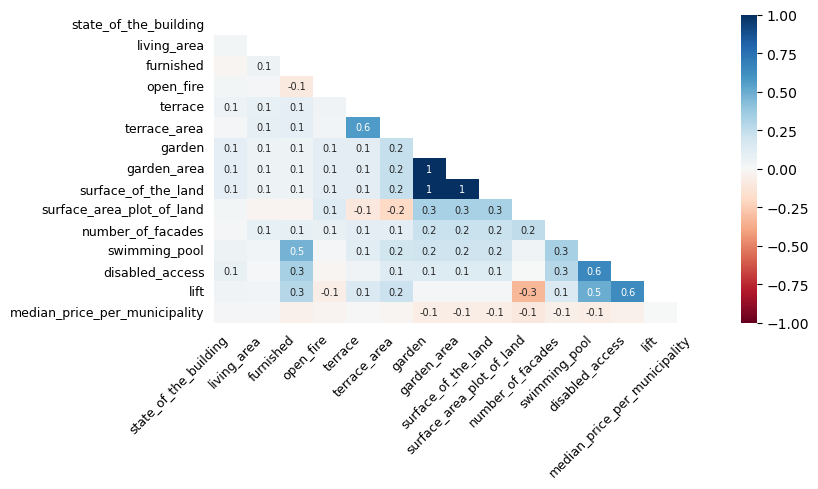

In [14]:
msno.heatmap(real_estate_data, figsize=(8, 4), fontsize=9)

<Axes: >

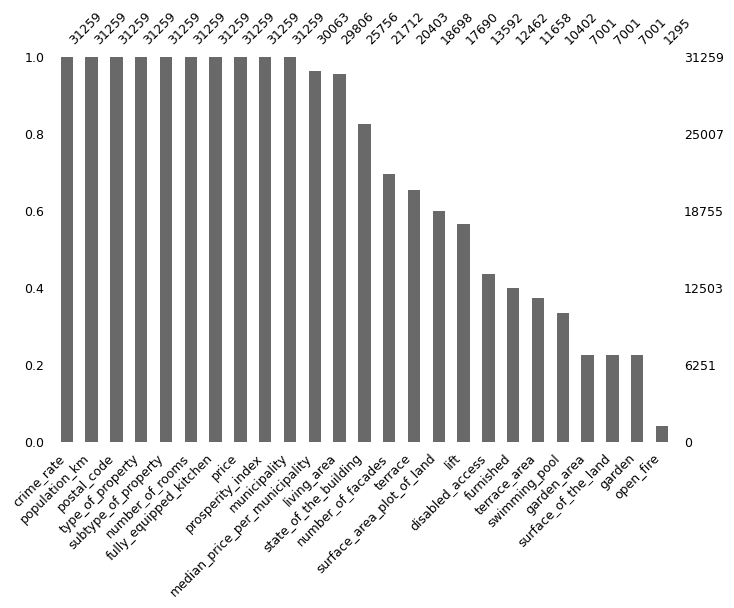

In [15]:
# Visualize the count of non-null values for each column
msno.bar(real_estate_data, figsize=(8, 5), fontsize=9, sort="descending")

<Axes: >

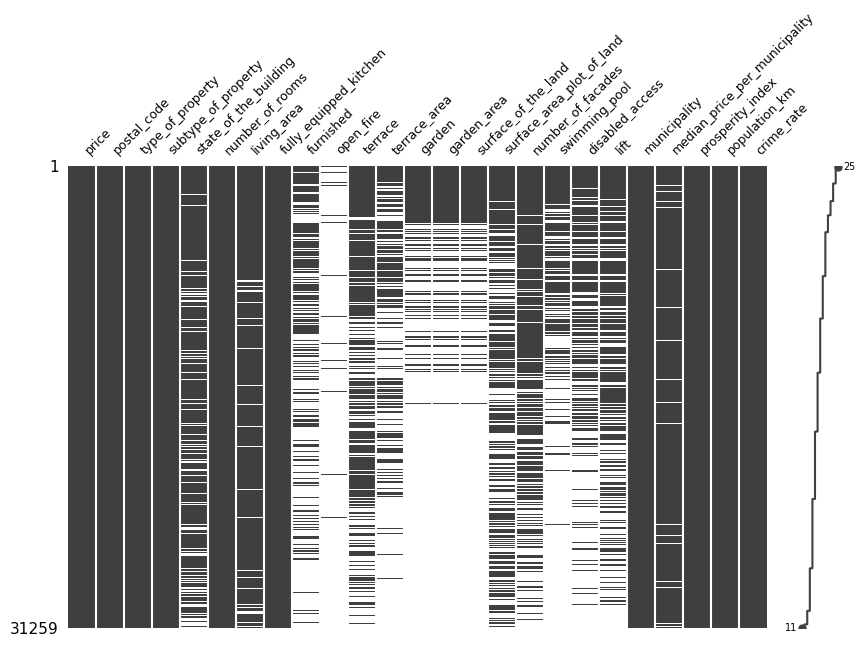

In [16]:
sorted_data = msno.nullity_sort(real_estate_data, sort='descending') 
msno.matrix(sorted_data, figsize=(10, 6), fontsize=9)

* Missing values | Categorical variables

In [17]:
# Convert 'Type_of_Property' to 1/0: 1 for 'house', 0 for 'apartment'
real_estate_data['type_of_property'] = real_estate_data['type_of_property'].map({'house': 1, 'apartment': 0})

The feature 'open_fire' indicates the total number of chimneys each observation has. Since the exact count is not needed, this column will be transformed into a boolean column, representing whether an observation has a chimney or not.

In [18]:
real_estate_data.head(10)

,price,postal_code,type_of_property,subtype_of_property,state_of_the_building,number_of_rooms,living_area,fully_equipped_kitchen,furnished,open_fire,...,surface_area_plot_of_land,number_of_facades,swimming_pool,disabled_access,lift,municipality,median_price_per_municipality,prosperity_index,population_km,crime_rate
0,148000.0,8930,1,house,as_new,3.0,149.0,0,NaN,NaN,...,162.0,2.0,NaN,0.0,0.0,menen,180625.0,91.0,1037.796922,27.573583
1,499850.0,9552,1,house,NaN,4.0,177.0,1,NaN,NaN,...,0.0,3.0,NaN,NaN,NaN,herzele,316250.0,114.0,395.116372,12.573964
2,225000.0,8434,0,apartment,good,2.0,61.0,0,1.0,NaN,...,NaN,NaN,NaN,NaN,1.0,middelkerke,225000.0,107.0,251.206331,19.944598
3,445000.0,8340,0,apartment,good,3.0,105.0,0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,damme,405000.0,111.0,124.022485,6.335326
4,269000.0,2060,0,apartment,just_renovated,2.0,72.0,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,antwerpen,285000.0,87.0,2666.254939,38.339890
5,395000.0,3570,0,penthouse,as_new,3.0,174.0,1,NaN,NaN,...,NaN,4.0,NaN,NaN,0.0,alken,290000.0,112.0,422.095387,8.642390
6,465000.0,8370,0,apartment,as_new,2.0,93.0,1,0.0,NaN,...,NaN,2.0,0.0,0.0,1.0,blankenberge,243000.0,102.0,1081.022019,31.567683
7,209000.0,2300,0,apartment,NaN,1.0,68.0,0,NaN,NaN,...,NaN,3.0,NaN,NaN,1.0,turnhout,243937.5,93.0,834.135994,26.297432
8,379000.0,3940,1,house,good,3.0,284.0,0,NaN,NaN,...,449.0,NaN,NaN,NaN,NaN,hechtel-eksel,295500.0,98.0,169.086404,11.955264
9,299000.0,5530,0,ground_floor,as_new,2.0,96.0,0,0.0,NaN,...,NaN,3.0,0.0,1.0,NaN,yvoir,242500.0,105.0,159.984240,12.587566


In [19]:
# Fill missing values wirh zero and replace all non-zero with 1
real_estate_data['open_fire'] = real_estate_data['open_fire'].fillna(0)
real_estate_data['open_fire'] = real_estate_data['open_fire'].apply(lambda x: 1 if x != 0 else 0)

The dataframe contains 8 boolean columns, where 1 represents True and 0 represents False, indicating whether an observation has specific features.
For these columns, all missing values will be assumed to represent False, meaning the observation does not have that feature.

The 8 boolean columns are:
* fully_equipped_kitchen
* furnished
* open_fire
* terrace
* garden
* swimming_pool
* disabled_access
* lift

In [20]:
# Fill missing values in boolean columns with 0 = False
boolean_columns = ['furnished',
                'open_fire',
                'terrace',
                'garden',
                'swimming_pool',
                'disabled_access', 
                'lift']

real_estate_data[boolean_columns] = real_estate_data[boolean_columns].fillna(0)

The 'state of the building' column contains categorical variables. The missing values in this column are MCAR: Missing Completely At Random and account for 15.756% of the total observations. Mode imputation will be applied, as it is the most appropriate method for categorical variables. Before imputation, the data will be grouped by 'type_of_property' and 'municipality.' Observations that do not have a matching group will be imputed using the global mode.

In [21]:
# Calculate the mode for each group (type_of_property, municipality)
mode_values = real_estate_data.groupby(['type_of_property', 'municipality'])['state_of_the_building'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)

# Impute missing values 'state_of_the_building' with the mode of the corresponding group
def impute_with_group_mode(row):
    if pd.isna(row['state_of_the_building']):
        group_mode = mode_values.get((row['type_of_property'], row['municipality']))
        return group_mode
    return row['state_of_the_building']

# Apply the function to the 'state_of_the_building' column
real_estate_data['state_of_the_building'] = real_estate_data.apply(impute_with_group_mode, axis=1)

# Fill the remaining missing values with the global mode
real_estate_data['state_of_the_building'] = real_estate_data['state_of_the_building'].fillna(real_estate_data['state_of_the_building'].mode()[0])

* Missing values | Numerical variables

In [22]:
# 'surface_of_the_land' | Check if two columns are the same
are_columns_equal = real_estate_data['surface_of_the_land'].equals(real_estate_data['garden_area'])
if are_columns_equal:
    print("The 'surface_of_the_land' and 'garden_area' columns contain identical data.")
else:
    print("The 'surface_of_the_land' and 'garden_area' columns have different values.")

The 'surface_of_the_land' and 'garden_area' columns contain identical data.


The column 'surface_of_the_land' will be dropped as it contains the same data as the column 'garden_area'.

In [23]:
# delete Surface_of_the_Land column
del real_estate_data['surface_of_the_land']

In [24]:
# Missing values for houses with a garden
missing_apartments_with_garden = real_estate_data[(real_estate_data['type_of_property'] == 0) & 
                                            (real_estate_data['garden'] == 1) & 
                                            (real_estate_data['garden_area'].isna())].shape[0]

# Missing values for apartments with a garden
missing_houses_with_garden = real_estate_data[(real_estate_data['type_of_property'] == 1) & 
                                                (real_estate_data['garden'] == 1) & 
                                                (real_estate_data['garden_area'].isna())].shape[0]

print(f"Missing values in garden area for houses with gardens: {missing_houses_with_garden}")
print(f"Missing values in garden area for apartments with gardens: {missing_apartments_with_garden}")

Missing values in garden area for houses with gardens: 0
Missing values in garden area for apartments with gardens: 0


All missing values in 'terrace_area' and 'garden_area' belong to observations that don't have a terrace or garden. Since the feature doesn't exist, the missing values are being filled with area = 0

In [25]:
real_estate_data['garden_area'] = real_estate_data['garden_area'].fillna(0)
real_estate_data['terrace_area'] = real_estate_data['terrace_area'].fillna(0)

The columns 'garden_area' and 'terrace_area' represent both exterior spaces. 

In [26]:
# Create new column 'ext_area' as the sum of 'garden_area' and 'terrace_area'
real_estate_data['ext_area'] = real_estate_data['garden_area'] + real_estate_data['terrace_area']

# Drop the 'garden_area' and 'terrace_area' columns
real_estate_data.drop(['garden_area', 'terrace_area'], axis=1, inplace=True)

There are many observation without zero as value for 'ext_area'. If the house has or not garden or terrace would give the same information for all properties. 

In [27]:
del real_estate_data['ext_area']

In [28]:
# Create a new column 'exterior_space' by combining 'garden' and 'terrace'
real_estate_data['garden'] = real_estate_data['garden'].astype(int)
real_estate_data['terrace'] = real_estate_data['terrace'].astype(int)

real_estate_data['exterior_space'] = (real_estate_data['garden'] | real_estate_data['terrace']).astype(int)

# Drop the 'garden' and 'terrace' columns
real_estate_data.drop(['garden', 'terrace'], axis=1, inplace=True)

In [29]:
# Create a new column by combining 'disabled_access' and 'lift'
real_estate_data['disabled_access'] = real_estate_data['disabled_access'].astype(int)
real_estate_data['lift'] = real_estate_data['lift'].astype(int)

real_estate_data['accessible'] = (real_estate_data['disabled_access'] | real_estate_data['lift']).astype(int)

# Drop the 'garden' and 'terrace' columns
real_estate_data.drop(['lift', 'disabled_access'], axis=1, inplace=True)

In [30]:
# Calculate the percentage of apartments with 0 as 'exterior_space'
percentage_zero_exterior_space = (real_estate_data['exterior_space'] == 0).mean() * 100

print(f"Percentage of apartments with 0 as 'exterior_space': {percentage_zero_exterior_space:.2f}%")

Percentage of apartments with 0 as 'exterior_space': 28.99%


The column 'living_area' contains a continuous variable and has only 3.639% of missing values.

Median imputation will be used, as it is the most appropriate method when the distribution of the data is skewed. Before imputing, the data will be grouped by 'type_of_property' and 'municipality.' Observations with no matching group will be imputed with the global median.

In [31]:
# Group by 'type_of_property' and 'municipality' and calculate the median of 'living_area'
median_values = real_estate_data.groupby(['type_of_property', 'municipality'])['living_area'].median()

# Impute missing values 'living_area' with the median of the corresponding group
def impute_with_group_median(row):
    if pd.isna(row['living_area']):
        return median_values.loc[(row['type_of_property'], row['municipality'])]
    return row['living_area']

# Apply the function to the 'living_area' column
real_estate_data['living_area'] = real_estate_data.apply(impute_with_group_median, axis=1)

# Fill the remaining missing values with the global median
real_estate_data['living_area'] = real_estate_data['living_area'].fillna(real_estate_data['living_area'].median())

In [32]:
real_estate_data['living_area'].describe()

count    31259.000000
mean       166.783454
std        127.719486
min         12.000000
25%         94.000000
50%        140.000000
75%        198.000000
max       4829.000000
Name: living_area, dtype: float64

The 'number_of_facades' column contains discrete numerical variables. The missing values in this column are MCAR: Missing Completely At Random, and account for  29.915% of the total observations. 

Mode imputation will be used, as it is the most appropriate method when data is discrete. Before imputing, the data will be grouped by 'type_of_property' and 'municipality.' Observations with no matching group will be imputed with the global median.

In [33]:
# Group by 'type_of_property' and 'municipality' and calculate the mode of 'number_of_facades' for each group
median_values_facades = real_estate_data.groupby(['type_of_property', 'municipality'])['number_of_facades'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)

# Impute missing values 'number_of_facades' with the median of corresponding group
def impute_with_group_mode(row):
    if pd.isna(row['number_of_facades']):
        return median_values_facades.loc[(row['type_of_property'], row['municipality'])]
    return row['number_of_facades']

# Apply the function to the 'number_of_facades' column
real_estate_data['number_of_facades'] = real_estate_data.apply(impute_with_group_mode, axis=1)

# Fill the remaining missing values with global median
real_estate_data['number_of_facades'] = real_estate_data['number_of_facades'].fillna(real_estate_data['number_of_facades'].mode()[0])

Zero is not a valid value for the feature 'surface_area_plot_of_land'. All zeros are being converted to NaN in order to facilitate imputation in the next steps.

In [34]:
# Fill 'Surface_area_plot_of_land' zeros with np.nan 
real_estate_data['surface_area_plot_of_land'] = real_estate_data['surface_area_plot_of_land'].replace(0, np.nan)

In [35]:
# Count the number of apartments and houses with non-missing 'surface_area_plot_of_land'
apartment_with_surface = real_estate_data[(real_estate_data['type_of_property'] == 0) & (real_estate_data['surface_area_plot_of_land'].notna())].shape[0]
house_with_surface = real_estate_data[(real_estate_data['type_of_property'] == 1) & (real_estate_data['surface_area_plot_of_land'].notna())].shape[0]

print(f"Number of apartments with surface area: {apartment_with_surface}")
print(f"Number of houses with surface area: {house_with_surface}")

# Calculate the percentage of missing surface area for apartments and houses
apartment_missing_surface = real_estate_data[(real_estate_data['type_of_property'] == 0) & (real_estate_data['surface_area_plot_of_land'].isna())].shape[0]
house_missing_surface = real_estate_data[(real_estate_data['type_of_property'] == 1) & (real_estate_data['surface_area_plot_of_land'].isna())].shape[0]

total_apartments = real_estate_data[real_estate_data['type_of_property'] == 0].shape[0]
total_houses = real_estate_data[real_estate_data['type_of_property'] == 1].shape[0]

apartment_missing_percentage = (apartment_missing_surface / total_apartments) * 100 if total_apartments > 0 else 0
house_missing_percentage = (house_missing_surface / total_houses) * 100 if total_houses > 0 else 0

print(f"Percentage of apartments without surface area: {apartment_missing_percentage:.2f}%")
print(f"Percentage of houses without surface area: {house_missing_percentage:.2f}%")

Number of apartments with surface area: 0
Number of houses with surface area: 17423
Percentage of apartments without surface area: 100.00%
Percentage of houses without surface area: 6.82%


In the column 'surface_area_plot_of_land' the missing values are related to the type of property. The percentage of missing values in houses is 6.6%, while the percentage of missing values in apartments is 100%.

Houses come with plots of land because they are standalone properties with space for construction and outdoor features, while apartments are part of a larger building and generally do not include separate land.

In this case, it will be assumed that all missing 'surface_area_plot_of_land' values in apartments are equal to their living area

In [36]:
real_estate_data.loc[real_estate_data['surface_area_plot_of_land'].isna() & (real_estate_data['type_of_property'] == 0), 'surface_area_plot_of_land'] = real_estate_data['living_area']

For the 5.62% of missing values in houses median imputation will be used, as it is the most appropriate method when the distribution of the data is skewed. Before imputing, the data will be grouped by 'number of facades' and 'municipality.' Observations with no matching group will be imputed with the global median.

In [37]:
# Group by 'type_of_property' and 'municipality' and calculate the median of 'living_area'
median_values = real_estate_data.groupby(['number_of_facades', 'municipality'])['surface_area_plot_of_land'].median()

# Impute missing values 'living_area' with the median of the corresponding group
def impute_with_group_median(row):
    if pd.isna(row['surface_area_plot_of_land']):
        return median_values.loc[(row['number_of_facades'], row['municipality'])]
    return row['surface_area_plot_of_land']

# Apply the function to the 'living_area' column
real_estate_data['surface_area_plot_of_land'] = real_estate_data.apply(impute_with_group_median, axis=1)

# Fill the remaining missing values with the global median
real_estate_data['surface_area_plot_of_land'] = real_estate_data['surface_area_plot_of_land'].fillna(real_estate_data['surface_area_plot_of_land'].median())

In [38]:
# Calculate the percentage of observations that are apartments
apartment_count = real_estate_data[real_estate_data['type_of_property'] == 0].shape[0]
total_count = real_estate_data.shape[0]
apartment_percentage = (apartment_count / total_count) * 100
print(f"Percentage of apartments: {apartment_percentage:.2f}%")

Percentage of apartments: 40.18%


Surface_area_plot_of_land repeats information from another feature for apartments, which represent 42% of the dataset. There are two other features related to property size: living_area and exterior_area, which represent the garden and terrace space.

In [39]:
del real_estate_data['surface_area_plot_of_land']

In [40]:
real_estate_data = real_estate_data.dropna(subset=['median_price_per_municipality'])

In [41]:
# Column summary
summary = []
for col in real_estate_data.columns:
    missing_count = real_estate_data[col].isnull().sum()  
    missing_percentage = np.round(real_estate_data[col].isnull().mean() * 100, 3)
    unique = real_estate_data[col].nunique()
    summary.append([missing_count, f'{missing_percentage}%', unique])

# Create a DataFrame with summary
summary_df = pd.DataFrame(summary, index=real_estate_data.columns, columns=['Missing Count', 'Missing Percentage', 'Unique Values'])
print(summary_df)

                               Missing Count Missing Percentage  Unique Values
price                                      0               0.0%           2501
postal_code                                0               0.0%            781
type_of_property                           0               0.0%              2
subtype_of_property                        0               0.0%             23
state_of_the_building                      0               0.0%              6
number_of_rooms                            0               0.0%             29
living_area                                0               0.0%            815
fully_equipped_kitchen                     0               0.0%              2
furnished                                  0               0.0%              2
open_fire                                  0               0.0%              2
number_of_facades                          0               0.0%              7
swimming_pool                              0        

***

* Define columns per type of data

In [42]:
# Binary columns
binary_columns = [
    col for col in real_estate_data.select_dtypes(include=['int64', 'float64']).columns 
    if real_estate_data[col].nunique() == 2
]

# Discrete Columns
discrete_columns = ['number_of_rooms', 'number_of_facades']

# Continuous columns
continuous_columns = [
    col for col in real_estate_data.select_dtypes(include=['float64', 'int64']).columns 
    if col not in discrete_columns 
    and col not in binary_columns
    and col not in ['postal_code']  
]

# Categorical columns
categorical_columns = (
    real_estate_data.select_dtypes(include=['object', 'category']).columns.tolist()
    + binary_columns
    + ['postal_code']  
)

print("Binary columns:",  binary_columns)
print("Discrete columns:", discrete_columns)
print("Continuous columns:", continuous_columns)
print("Categorical columns:", categorical_columns)

Binary columns: ['type_of_property', 'fully_equipped_kitchen', 'furnished', 'open_fire', 'swimming_pool', 'exterior_space', 'accessible']
Discrete columns: ['number_of_rooms', 'number_of_facades']
Continuous columns: ['price', 'living_area', 'median_price_per_municipality', 'prosperity_index', 'population_km', 'crime_rate']
Categorical columns: ['subtype_of_property', 'state_of_the_building', 'municipality', 'type_of_property', 'fully_equipped_kitchen', 'furnished', 'open_fire', 'swimming_pool', 'exterior_space', 'accessible', 'postal_code']


***

#### Validation of categorical features

In [43]:
# Unique values in 'municipality'
real_estate_data['municipality'].value_counts()

municipality
antwerpen       2493
knokke-heist    1411
gent            1353
liège            692
oostende         669
                ... 
quévy              5
hensies            4
estinnes           4
limbourg           3
as                 1
Name: count, Length: 410, dtype: int64

The categorical column 'municipality' has high cardinality (509 unique values). This feature was used to create new features ('crime_rate', 'population_km', and 'prosperity_index') that contain the most important information related to specific locations. These feature can be delete. Province and region are gives the same iformation as municipality. 

In [44]:
# Unique values in 'type_of_property'
real_estate_data['type_of_property'].value_counts()

type_of_property
1    17679
0    12384
Name: count, dtype: int64

In [45]:
# Unique values in 'Subtype_of_Property'
real_estate_data['subtype_of_property'].value_counts()

subtype_of_property
house                   13499
apartment                9869
villa                    1629
apartment_block           700
mixed_use_building        649
ground_floor              632
duplex                    620
penthouse                 455
flat_studio               429
exceptional_property      252
mansion                   252
town_house                220
bungalow                  185
service_flat              167
country_cottage           140
loft                       92
kot                        66
farmhouse                  65
triplex                    54
chalet                     36
manor_house                24
castle                     16
other_property             12
Name: count, dtype: int64

In [46]:
# Label all 'other_property' as the corresponding 'type_of_property'
real_estate_data.loc[real_estate_data['subtype_of_property'] == 'other_property', 'subtype_of_property'] = real_estate_data['type_of_property']

# Group by the 'subtype' column and count the occurrences of each 'property_type' within each 'subtype'
real_estate_data.groupby('subtype_of_property')['type_of_property'].value_counts().unstack(fill_value=0)

# Calculates the percentage of properties where the 'subtype_of_property' column 
# repeats information already present in the 'type_of_property' column ('house' or 'apartment'), 
# and the percentage of properties with a new value that adds unique information. 

total_properties = len(real_estate_data)
subtype_counts = real_estate_data['subtype_of_property'].value_counts()
percentage_by_subtype = (subtype_counts / total_properties) * 100

house_apartment_percentage = percentage_by_subtype[['house', 'apartment']].sum()
other_subtypes_percentage = 100 - house_apartment_percentage

print(f"Percentage of properties in 'house' and 'apartment' subtypes: {house_apartment_percentage:.2f}%")
print(f"Percentage of properties in other subtypes: {other_subtypes_percentage:.2f}%")

Percentage of properties in 'house' and 'apartment' subtypes: 77.73%
Percentage of properties in other subtypes: 22.27%


Only 23% of the observations have a new value in the 'subtype_of_property' column, while 77.36% repeat information that is already present in the 'type_of_property' column.

In [47]:
del real_estate_data['subtype_of_property']

In [48]:
# Unique values in 'state_of_the_building'
real_estate_data['state_of_the_building'].value_counts()

state_of_the_building
good              16089
as_new             6598
to_renovate        2955
to_be_done_up      2337
just_renovated     1920
to_restore          164
Name: count, dtype: int64

# Data cleaning | outliers

* Visualizing outliers in numerical variables

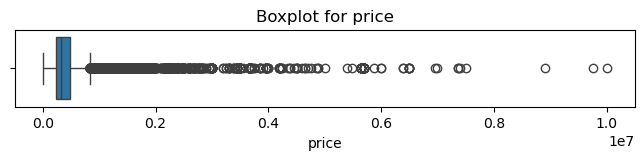

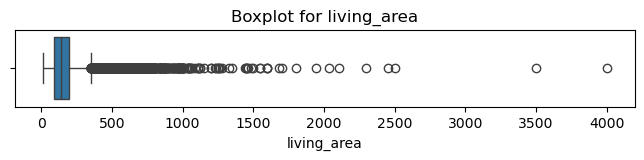

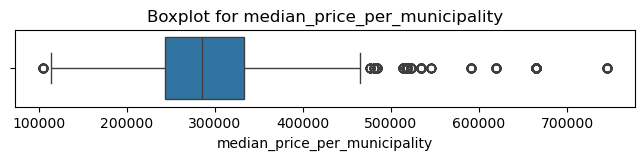

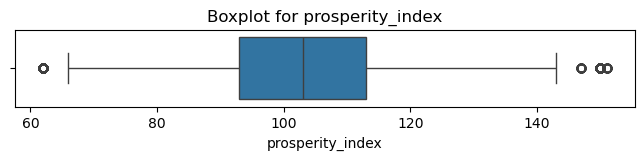

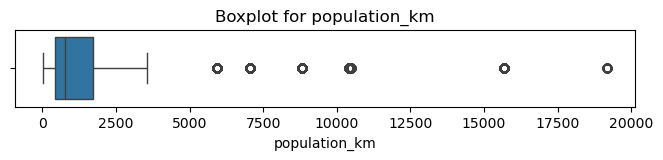

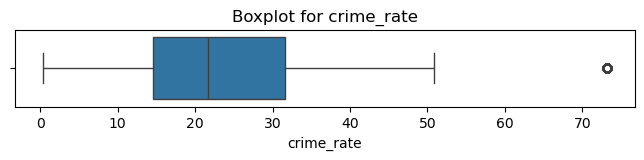

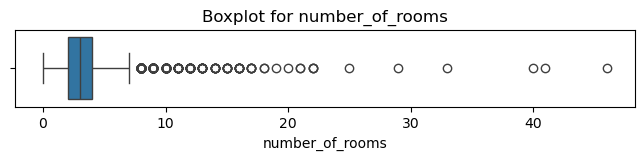

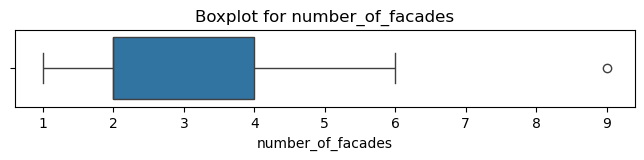

In [49]:
# Plot outlier in continuous and discrete columns   
numerical_columns = continuous_columns + discrete_columns
for column in numerical_columns:
   plt.figure(figsize=(8, 1))
   sns.boxplot(x=real_estate_data[column])
   plt.title(f'Boxplot for {column}')
   plt.show()

In [50]:
# Describe numerical columns
describe_numerical_columns = pd.DataFrame()
for col in numerical_columns:
    description = real_estate_data[col].describe().to_frame().T 
    description['skewness'] = real_estate_data[col].skew()
    description['kurtosis'] = real_estate_data[col].kurt()
    describe_numerical_columns = pd.concat([describe_numerical_columns, description], axis=0) 

describe_numerical_columns

,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis
price,30063.0,440870.534245,451380.042237,5000.000000,237500.000000,330000.000000,479356.000000,9.999000e+06,6.451844,68.218527
living_area,30063.0,165.015068,122.782222,12.000000,93.000000,139.000000,196.000000,4.000000e+03,5.539215,83.675052
median_price_per_municipality,30063.0,299435.146168,109048.919109,105000.000000,243937.500000,285000.000000,333125.000000,7.450000e+05,1.826329,4.185419
prosperity_index,30063.0,103.902006,17.467368,62.000000,93.000000,103.000000,113.000000,1.510000e+02,0.550334,0.882154
population_km,30063.0,1357.251931,1992.441179,27.604459,421.273465,771.007153,1708.806368,1.916196e+04,4.900643,30.707916
crime_rate,30063.0,24.375011,13.213624,0.374478,14.564742,21.628144,31.567683,7.312875e+01,1.323482,2.374820
number_of_rooms,30063.0,2.883578,1.542908,0.000000,2.000000,3.000000,4.000000,4.600000e+01,3.995309,64.101585
number_of_facades,30063.0,2.691248,0.854574,1.000000,2.000000,2.000000,4.000000,9.000000e+00,0.624513,-1.170769


All the numerical columns has positive skew (right-skewed).  

The columns 'living_area' and 'ext_area' have high kurtosis (leptokurtic); the distribution of these columns has more extreme outliers.    
The feature 'ext_area' has the highest skew, 23.17. This column has 27.78% of observations with 0.

In [51]:
# Shape of the df before deleting outliers
real_estate_data.shape

(30063, 18)

In [52]:
def detect_and_remove_outliers_iqr(column):
    """
    This function detects and removes outliers from a given numerical column using the IQR (Interquartile Range) method.
    
    Parameters: A numerical column or list to check for outliers.
    
    Returns: A cleaned version of the original column with outliers removed.
    
    Prints:
    - The outliers and their frequency in the original column.
    - The total number of outliers detected.
    """
    # Calculate IQR and bounds
    column_sorted = sorted(column)
    q1 = np.percentile(column_sorted, 25)
    q3 = np.percentile(column_sorted, 75)
    IQR = q3 - q1
    lwr_bound = q1 - (1.5 * IQR)
    upr_bound = q3 + (1 * IQR)

    # Detect outliers
    outliers = [i for i in column_sorted if i < lwr_bound or i > upr_bound]
    
    # Filter out outliers from original data
    column_cleaned = column[(column >= lwr_bound) & (column <= upr_bound)]
    
    # Print info about outliers
    print(f"Outliers:\n{pd.Series(outliers).value_counts().sort_index()}.")
    print(f"Total sum of outliers: {len(outliers)}")
    
    return column_cleaned

In [53]:
# Remove outliers from 'price' column
no_outliers_price = detect_and_remove_outliers_iqr(real_estate_data['price'])
real_estate_data = real_estate_data[real_estate_data['price'].isin(no_outliers_price)]

Outliers:
722933.0     1
723000.0     1
724009.0     1
724479.0     1
724500.0     1
            ..
7395000.0    1
7500000.0    1
8900000.0    1
9750000.0    1
9999000.0    1
Name: count, Length: 488, dtype: int64.
Total sum of outliers: 3318


In [54]:
# Remove outliers from 'living_area' column
no_outliers_living_area = detect_and_remove_outliers_iqr(real_estate_data['living_area'])
real_estate_data = real_estate_data[real_estate_data['living_area'].isin(no_outliers_living_area)]

Outliers:
272.0     20
273.0     14
274.0     13
275.0     25
276.0     14
          ..
1350.0     1
1439.0     1
1600.0     2
2034.0     1
3502.0     1
Name: count, Length: 312, dtype: int64.
Total sum of outliers: 1682


Usually only studios are know for having no separete room. All houses with 0 rooms will be change for the mode in the specific municipality

In [55]:
# Group by 'type_of_property' and 'municipality' and calculate the mode of 'number_of_rooms'
mode_values = real_estate_data.groupby(['type_of_property', 'municipality'])['number_of_rooms'].agg(lambda x: x.mode()[0])

# Function to replace 0s with the mode based on group, for houses only
def replace_with_mode(row):
    if row['number_of_rooms'] == 0 and row['type_of_property'] == 1:
        return mode_values.loc[(row['type_of_property'], row['municipality'])]
    return row['number_of_rooms']

# Apply the function to the 'number_of_rooms' column
real_estate_data['number_of_rooms'] = real_estate_data.apply(replace_with_mode, axis=1)

In [56]:
real_estate_data['number_of_rooms'].value_counts()

number_of_rooms
3.0     8850
2.0     8425
4.0     3475
1.0     2819
5.0      812
0.0      423
6.0      204
7.0       32
8.0       12
10.0       5
9.0        3
12.0       2
16.0       1
Name: count, dtype: int64

In [57]:
# Remove rows where 'number_of_rooms' is less than 10
real_estate_data = real_estate_data[real_estate_data['number_of_rooms'] < 7]

In [58]:
# Remove outliers from 'number_of_facades' column
no_outliers_number_of_facades = detect_and_remove_outliers_iqr(real_estate_data['number_of_facades'])
real_estate_data = real_estate_data[real_estate_data['number_of_facades'].isin(no_outliers_number_of_facades)]

Outliers:
5.0    6
6.0    2
9.0    1
Name: count, dtype: int64.
Total sum of outliers: 9


In [59]:
real_estate_data.shape

(24999, 18)

In [60]:
# Describe numerical columns
describe_numerical_columns = pd.DataFrame()
for col in numerical_columns:
    description = real_estate_data[col].describe().to_frame().T 
    description['skewness'] = real_estate_data[col].skew()
    description['kurtosis'] = real_estate_data[col].kurt()
    describe_numerical_columns = pd.concat([describe_numerical_columns, description], axis=0) 

describe_numerical_columns

,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis
price,24999.0,320359.703388,133854.302575,5000.000000,220000.000000,299000.000000,398000.000000,720874.000000,0.678360,0.068313
living_area,24999.0,131.939458,54.306807,12.000000,89.500000,125.000000,170.000000,271.000000,0.395753,-0.558540
median_price_per_municipality,24999.0,284042.645176,87333.280074,105000.000000,243000.000000,284412.500000,320250.000000,745000.000000,1.731270,5.964182
prosperity_index,24999.0,101.884955,15.576403,62.000000,92.000000,103.000000,110.000000,151.000000,0.287817,0.984052
population_km,24999.0,1399.422478,1992.329525,27.604459,426.553393,834.135994,1708.806368,19161.960361,4.781176,29.820067
crime_rate,24999.0,24.813942,13.514648,0.374478,14.676101,21.628144,32.099854,73.128748,1.285065,2.155626
number_of_rooms,24999.0,2.615265,1.065193,0.000000,2.000000,3.000000,3.000000,6.000000,0.239823,0.300115
number_of_facades,24999.0,2.613385,0.814953,1.000000,2.000000,2.000000,3.000000,4.000000,0.773582,-0.985078


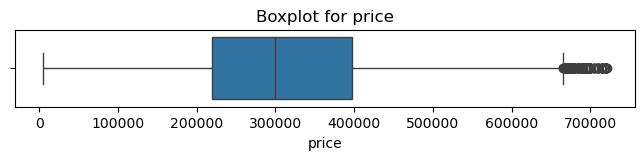

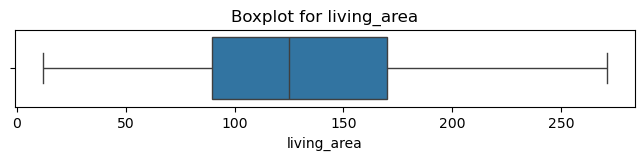

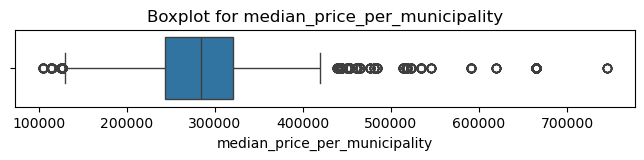

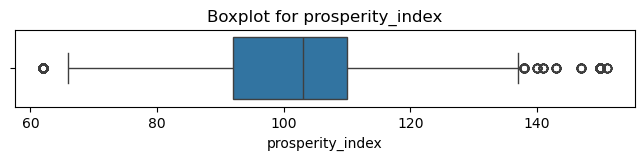

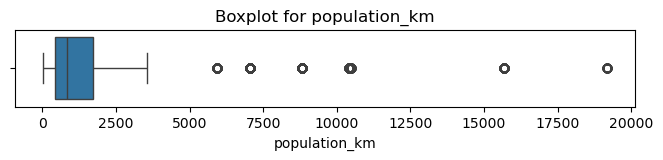

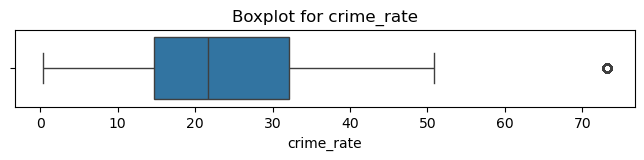

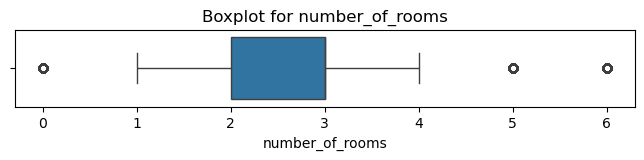

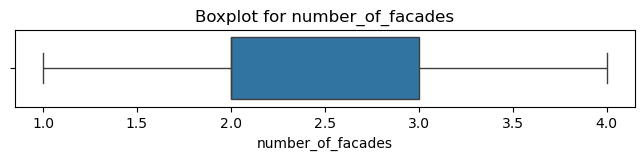

In [61]:
# Plot outlier in continuous and discrete columns   
numerical_columns = continuous_columns + discrete_columns
for column in numerical_columns:
   plt.figure(figsize=(8, 1))
   sns.boxplot(x=real_estate_data[column])
   plt.title(f'Boxplot for {column}')
   plt.show()

In [62]:
real_estate_data

,price,postal_code,type_of_property,state_of_the_building,number_of_rooms,living_area,fully_equipped_kitchen,furnished,open_fire,number_of_facades,swimming_pool,municipality,median_price_per_municipality,prosperity_index,population_km,crime_rate,exterior_space,accessible
0,148000.0,8930,1,as_new,3.0,149.0,0,0.0,0,2.0,0.0,menen,180625.0,91.0,1037.796922,27.573583,1,0
1,499850.0,9552,1,good,4.0,177.0,1,0.0,0,3.0,0.0,herzele,316250.0,114.0,395.116372,12.573964,1,0
2,225000.0,8434,0,good,2.0,61.0,0,1.0,0,2.0,0.0,middelkerke,225000.0,107.0,251.206331,19.944598,1,1
3,445000.0,8340,0,good,3.0,105.0,0,0.0,0,2.0,0.0,damme,405000.0,111.0,124.022485,6.335326,1,0
4,269000.0,2060,0,just_renovated,2.0,72.0,0,0.0,0,2.0,0.0,antwerpen,285000.0,87.0,2666.254939,38.339890,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33049,280000.0,9300,0,as_new,2.0,80.0,1,0.0,0,2.0,0.0,aalst,248500.0,105.0,1156.875981,18.682345,1,1
33050,350000.0,1040,0,as_new,1.0,56.0,0,1.0,0,2.0,0.0,etterbeek,324062.5,70.0,5948.885249,8.261020,1,1
33051,350000.0,1040,0,as_new,1.0,56.0,0,1.0,0,2.0,0.0,etterbeek,441875.0,83.0,15681.131322,32.667002,1,1
33052,249000.0,4870,1,good,4.0,153.0,0,0.0,0,2.0,0.0,olne,176000.0,101.0,332.174145,5.460412,1,0


In [63]:
del real_estate_data['municipality']

****

The 'state_of_the_building' and 'fully_equipped_kitchen' columns provide insights into the additional investment a buyer might need to make. These two columns will be combined into a new one called 'extra_investment,' where higher values represent less work required. 

Broader categories will be formed for the 'state_of_the_building' column based on its relationship with the price of the property. 


In [64]:
#  Define new categories
state_mapping = {
    'just_renovated': 3,
    'as_new': 4,
    'good': 3,
    'to_renovate': 2,
    'to_be_done_up': 2,
    'to_restore': 1
}
real_estate_data['state_of_the_building'] = real_estate_data['state_of_the_building'].map(state_mapping)

# Unique values in 'state_of_the_building'
print(real_estate_data['state_of_the_building'].value_counts())

state_of_the_building
3    15242
4     5054
2     4563
1      140
Name: count, dtype: int64


In [65]:
real_estate_data['extra_investment'] = real_estate_data['state_of_the_building'] + real_estate_data['fully_equipped_kitchen']

del real_estate_data['fully_equipped_kitchen']
del real_estate_data['state_of_the_building']

# Check the updated values
print(real_estate_data['extra_investment'].value_counts())

extra_investment
3    13563
4     5360
2     4462
5     1482
1      132
Name: count, dtype: int64


In [66]:
# Filter the 'postal_code' column
postal_code_counts = real_estate_data['postal_code'].value_counts()
valid_postal_code = postal_code_counts[postal_code_counts > 30].index
real_estate_data = real_estate_data[real_estate_data['postal_code'].isin(valid_postal_code)]

In [67]:
# Binary columns
binary_columns = [
    col for col in real_estate_data.select_dtypes(include=['int64', 'float64']).columns 
    if real_estate_data[col].nunique() == 2
]

# Discrete Columns
discrete_columns = ['number_of_rooms', 'number_of_facades','extra_investment']

# Continuous columns
continuous_columns = [
    col for col in real_estate_data.select_dtypes(include=['float64', 'int64']).columns 
    if col not in discrete_columns 
    and col not in binary_columns
    and col not in ['postal_code']  
]

# Categorical columns
categorical_columns = (
    real_estate_data.select_dtypes(include=['object', 'category']).columns.tolist()
    + binary_columns
    + ['postal_code']  
)

numerical_columns =  [discrete_columns + continuous_columns]

print("Binary columns:",  binary_columns)
print("Discrete columns:", discrete_columns)
print("Continuous columns:", continuous_columns)
print("Categorical columns:", categorical_columns)
print("Numerical_columns:", numerical_columns)


Binary columns: ['type_of_property', 'furnished', 'open_fire', 'swimming_pool', 'exterior_space', 'accessible']
Discrete columns: ['number_of_rooms', 'number_of_facades', 'extra_investment']
Continuous columns: ['price', 'living_area', 'median_price_per_municipality', 'prosperity_index', 'population_km', 'crime_rate']
Categorical columns: ['type_of_property', 'furnished', 'open_fire', 'swimming_pool', 'exterior_space', 'accessible', 'postal_code']
Numerical_columns: [['number_of_rooms', 'number_of_facades', 'extra_investment', 'price', 'living_area', 'median_price_per_municipality', 'prosperity_index', 'population_km', 'crime_rate']]


***

### Peek of correlations and check linear regression assumptions

* Discrete columns

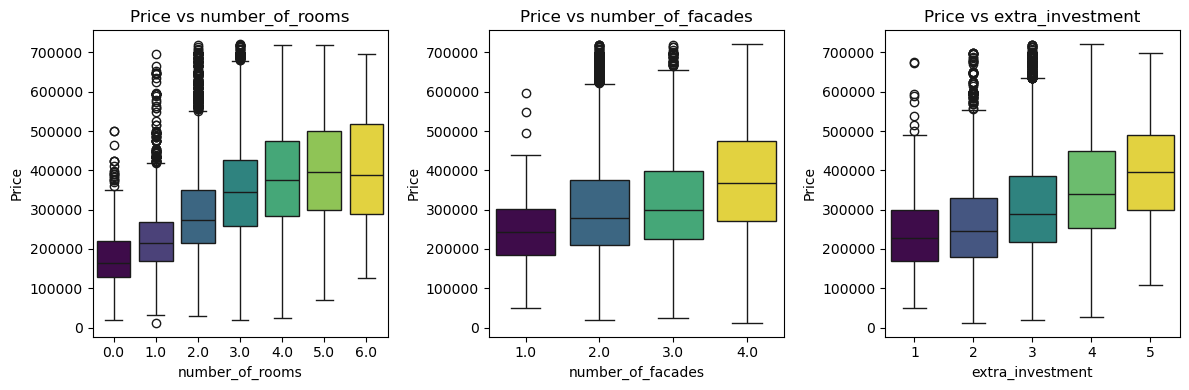

In [68]:
# Plot discrete_columns
fig, axes = plt.subplots(1, len(discrete_columns), figsize=(12, 4))

for i, col in enumerate(discrete_columns):
    sns.boxplot(data=real_estate_data, x=col, y='price', hue=col, palette='viridis', legend=False, ax=axes[i])
    axes[i].set_title(f'Price vs {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Price')

plt.subplots_adjust(wspace=3)

plt.tight_layout()
plt.show()

In [69]:
# Group by 'type_of_property' and calculate the mean for 'number_of_rooms' and 'number_of_facades'
rooms_per_property_type = real_estate_data.groupby('type_of_property')['number_of_rooms'].mean()
facades_per_property_type = real_estate_data.groupby('type_of_property')['number_of_facades'].mean()

print("Average number of rooms per type of property:")
print(rooms_per_property_type)
print("Average number of facades per type of property:")
print(facades_per_property_type)

Average number of rooms per type of property:
type_of_property
0    1.88987
1    3.19697
Name: number_of_rooms, dtype: float64
Average number of facades per type of property:
type_of_property
0    2.222391
1    2.759725
Name: number_of_facades, dtype: float64


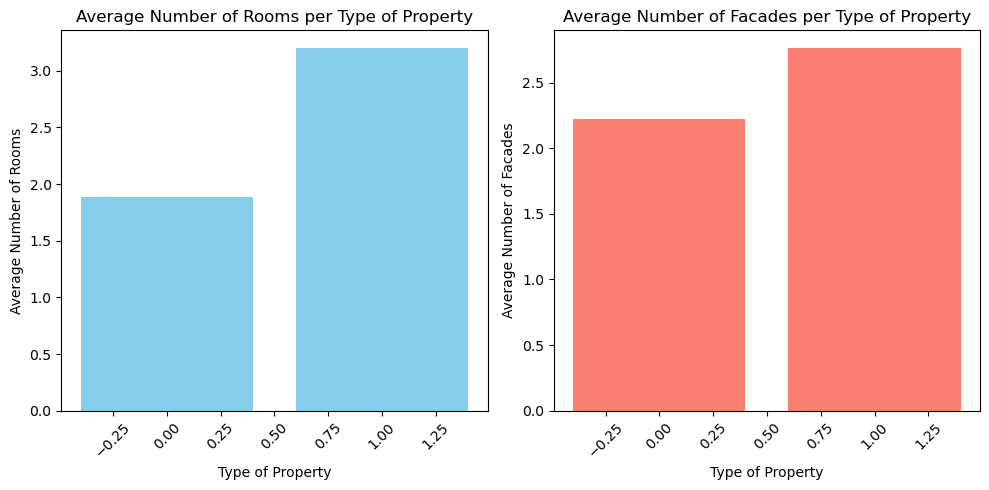

In [70]:
# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plotting the average number of rooms per type of property on the first subplot
axes[0].bar(rooms_per_property_type.index, rooms_per_property_type, color='skyblue')
axes[0].set_title('Average Number of Rooms per Type of Property')
axes[0].set_xlabel('Type of Property')
axes[0].set_ylabel('Average Number of Rooms')
axes[0].tick_params(axis='x', rotation=45)

# Plotting the average number of facades per type of property on the second subplot
axes[1].bar(facades_per_property_type.index, facades_per_property_type, color='salmon')
axes[1].set_title('Average Number of Facades per Type of Property')
axes[1].set_xlabel('Type of Property')
axes[1].set_ylabel('Average Number of Facades')
axes[1].tick_params(axis='x', rotation=45)

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plots
plt.show()

The number of rooms and number of facades provide information about the type of property. The column 'type_of_property' can be redundant.

* Binary columns

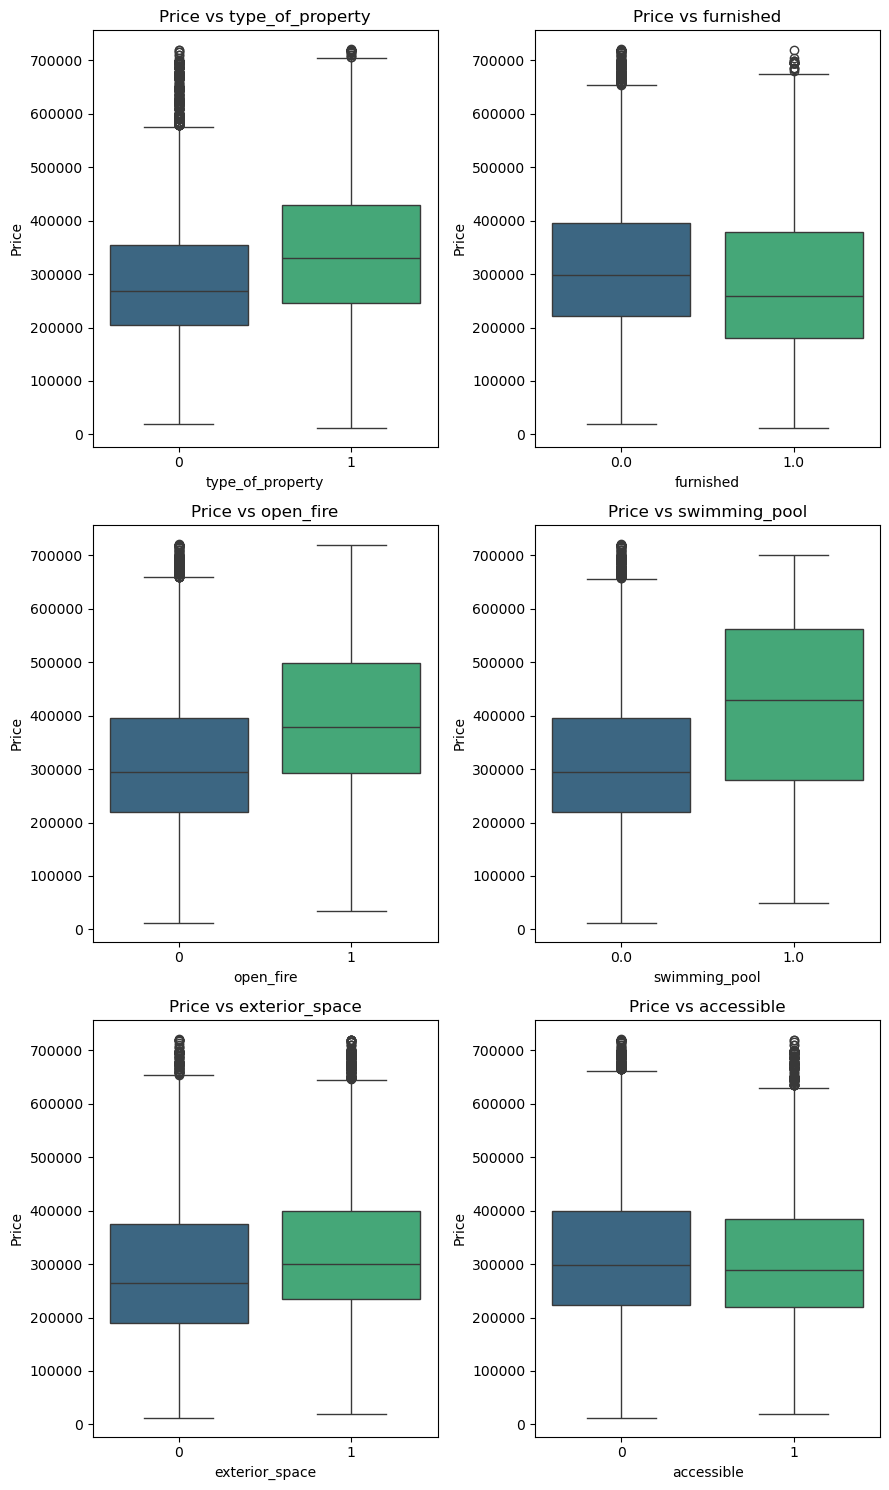

In [71]:
# Plot Binary columns
n_columns = len(binary_columns)
n_rows = (n_columns + 1) // 2  

fig, axes = plt.subplots(n_rows, 2, figsize=(9, n_rows * 5))

axes = axes.flatten()

for i, col in enumerate(binary_columns):
    sns.boxplot(data=real_estate_data, x=col, y='price', hue=col, palette='viridis', legend=False, ax=axes[i])
    axes[i].set_title(f'Price vs {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Price')

plt.subplots_adjust(wspace=0.4, hspace=0.5)  
plt.tight_layout()  
plt.show()

The columns 'accesible' and 'furnished' has no visible impact on price. 


In [72]:
real_estate_data = real_estate_data.drop(columns=['accessible', 'furnished'])

* Categorical columns

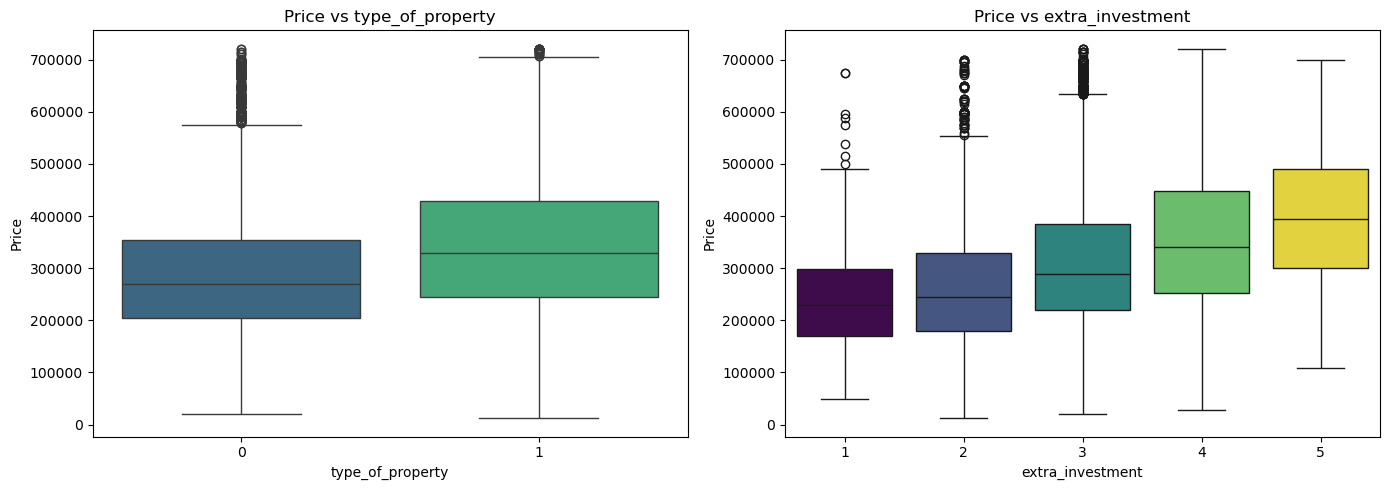

In [73]:
cat_columns = ['type_of_property', 'extra_investment']

# Plot discrete_columns
fig, axes = plt.subplots(1, len(cat_columns), figsize=(14, 5))

for i, col in enumerate(cat_columns):
    sns.boxplot(data=real_estate_data, x=col, y='price', hue=col, palette='viridis', legend=False, ax=axes[i])
    axes[i].set_title(f'Price vs {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Price')

plt.subplots_adjust(wspace=3)

plt.tight_layout()
plt.show()

* Continuous columns

<Figure size 600x400 with 0 Axes>

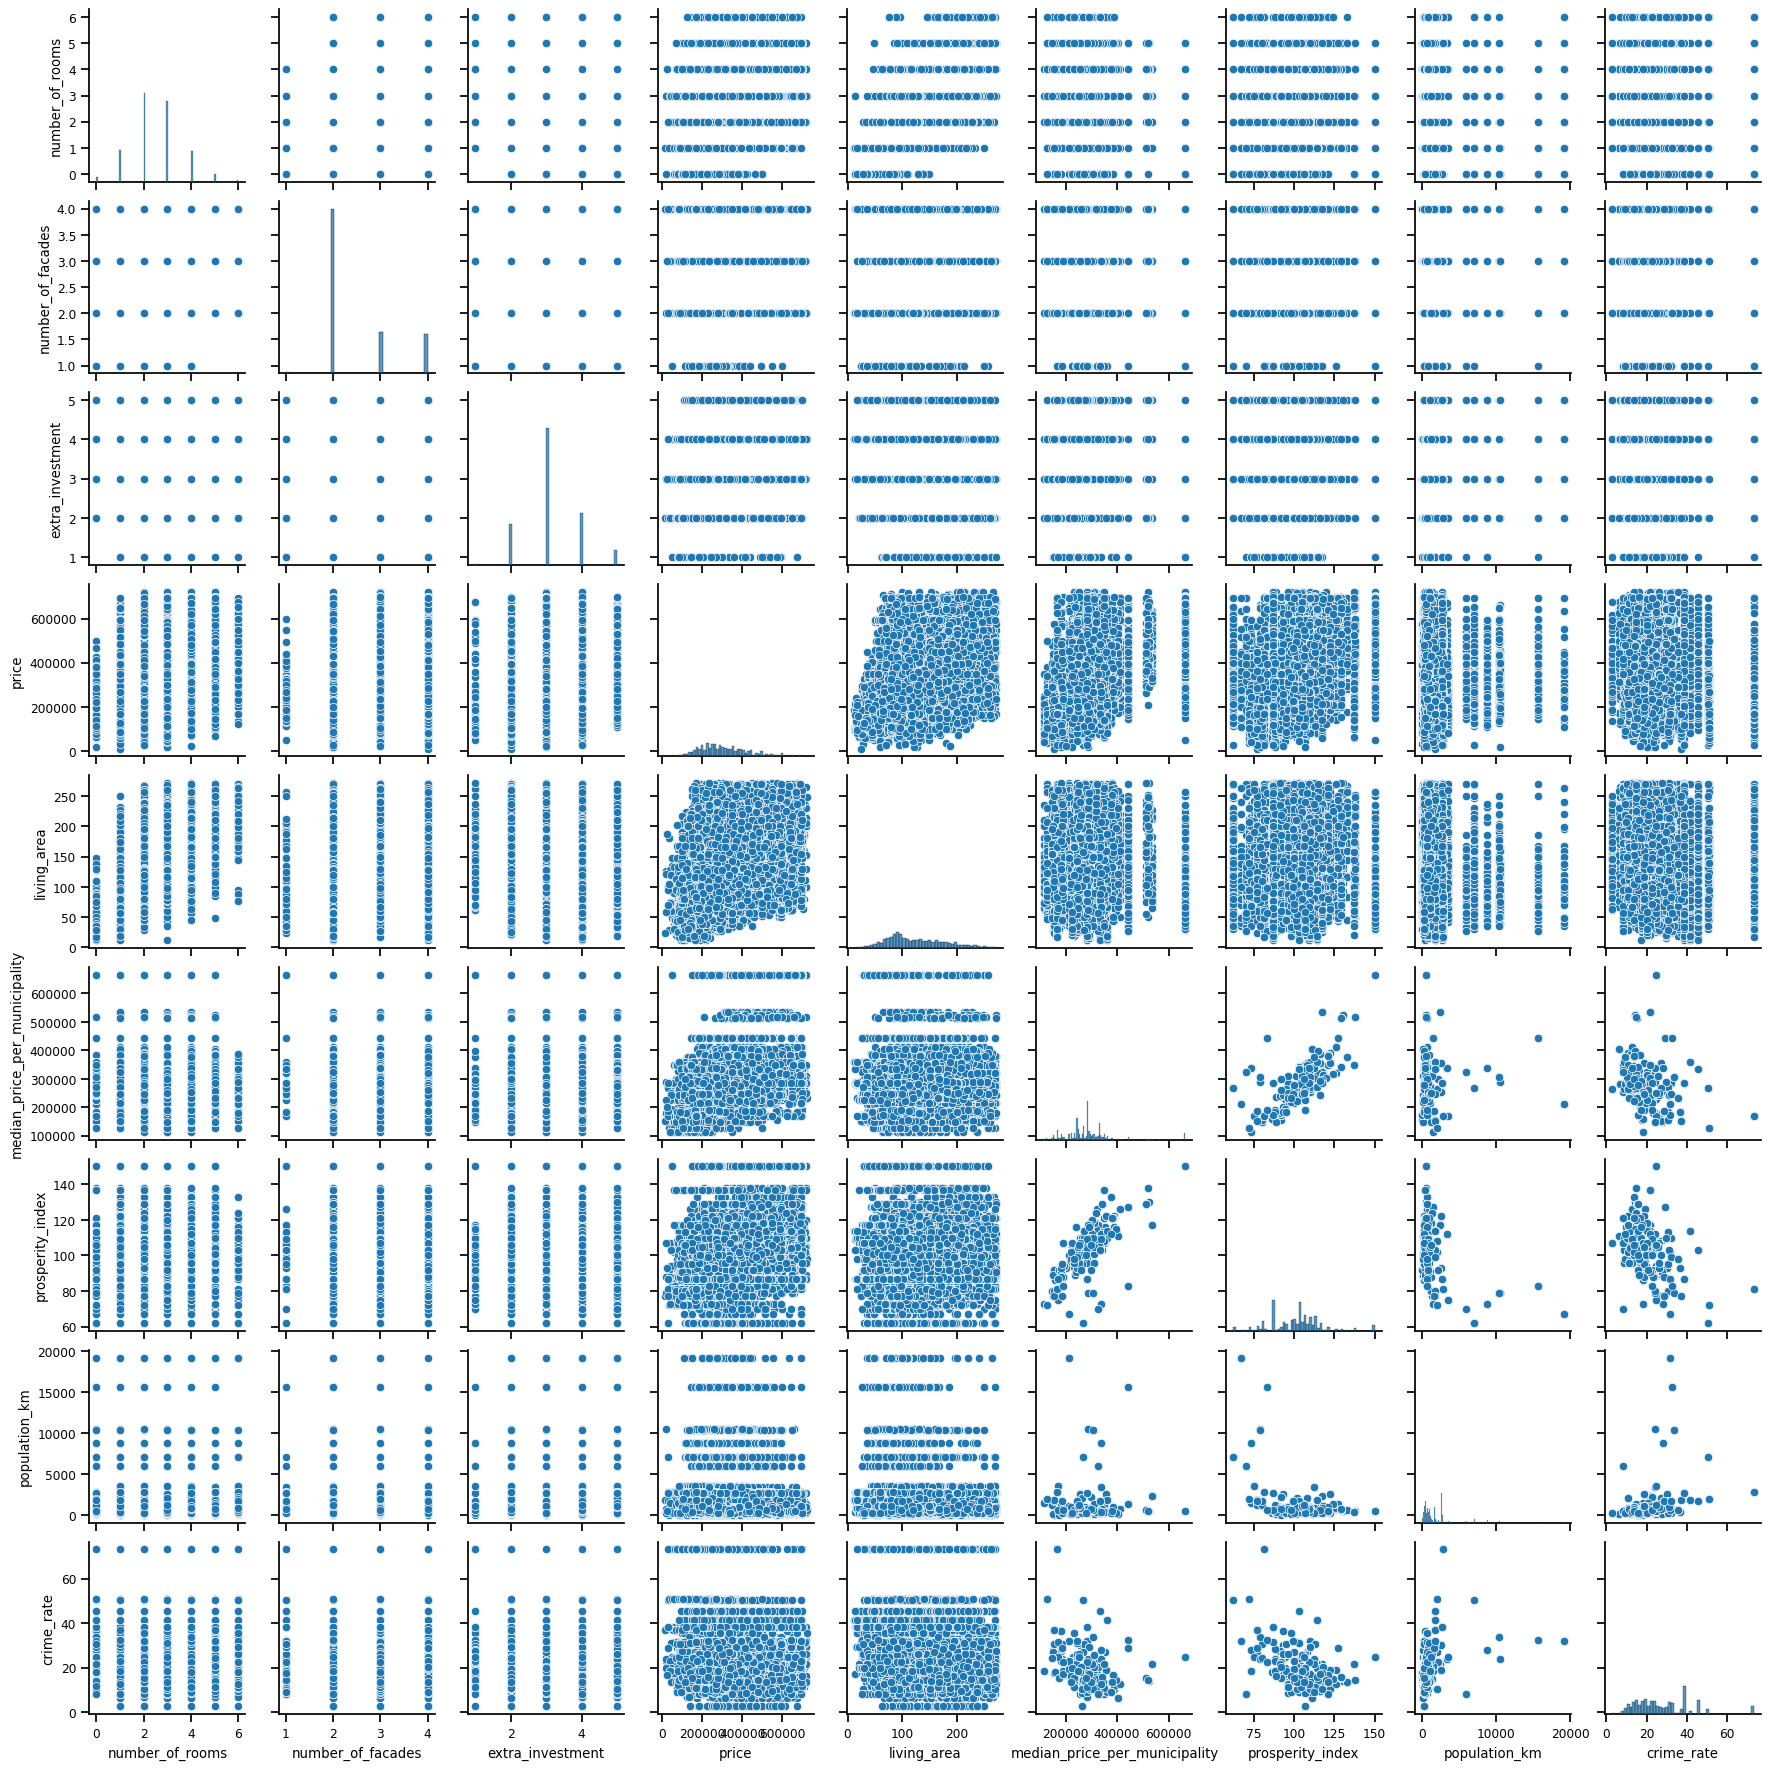

In [74]:
# Flatten numerical_columns 
numerical_columns_flat = discrete_columns + continuous_columns

# Plot pairwise relationships for numerical columns
plt.figure(figsize=(6, 4))
sns.set_context('notebook', font_scale=0.8)
sns.pairplot(real_estate_data[numerical_columns_flat], height=2)
plt.show()

The column "living_area" has a linear in the coefficients with target.

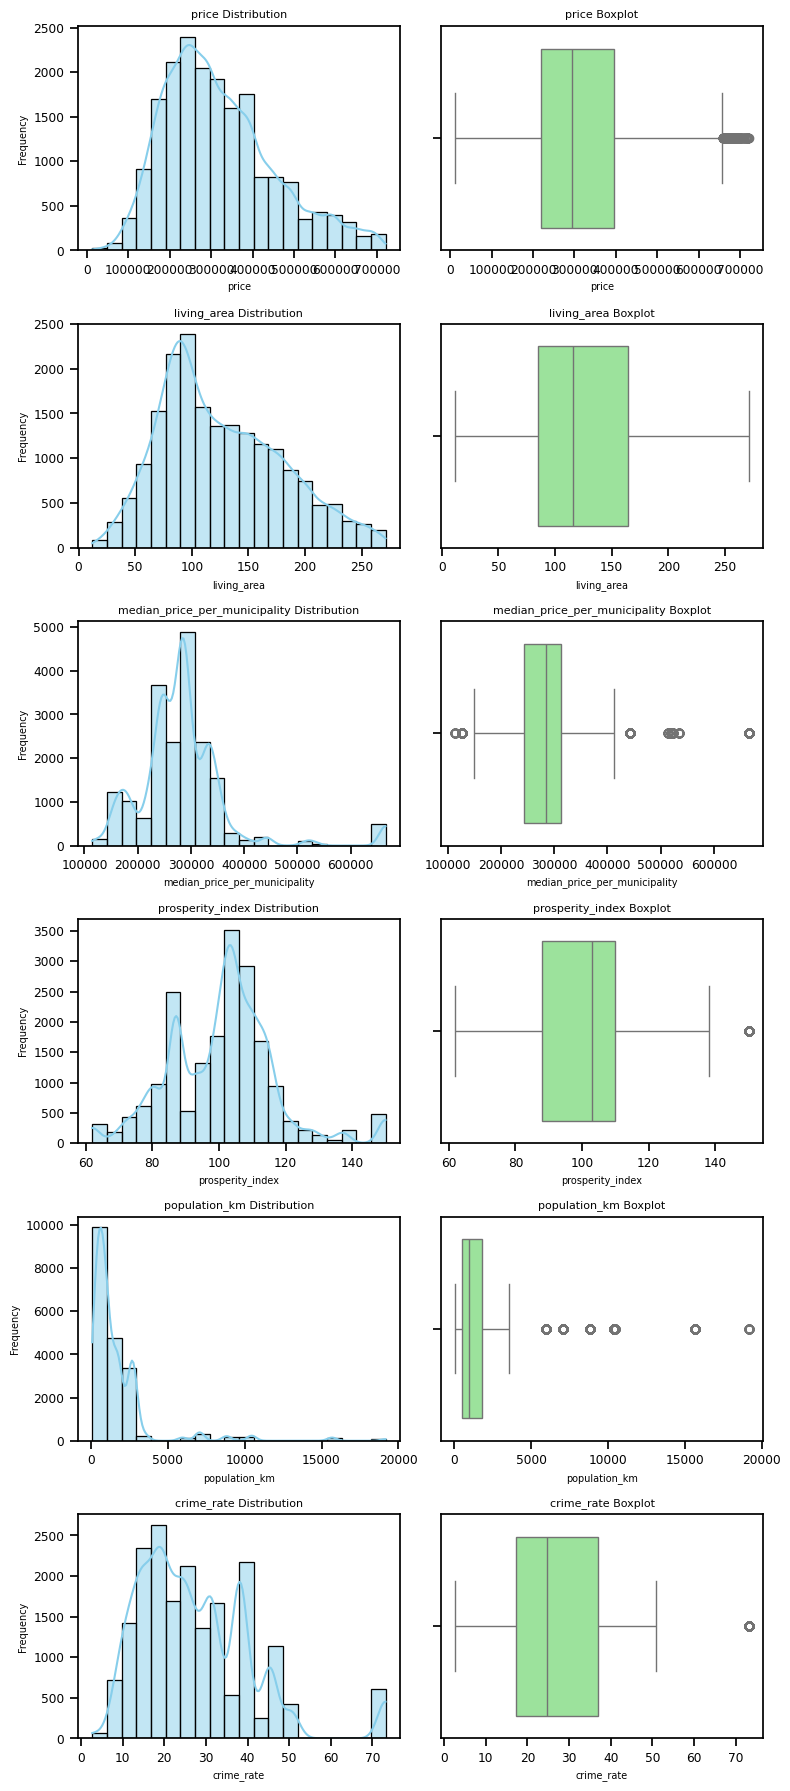

In [75]:
# Plot - histogram and boxplot - for continuous columns
fig, axes = plt.subplots(len(continuous_columns), 2, figsize=(8, len(continuous_columns) * 3))

for i, column in enumerate(continuous_columns):
    # Histogram with KDE
    sns.histplot(real_estate_data[column], kde=True, ax=axes[i, 0], color='skyblue', bins=20)
    axes[i, 0].set_title(f'{column} Distribution', fontsize=8)
    axes[i, 0].set_xlabel(column, fontsize=7)
    axes[i, 0].set_ylabel('Frequency', fontsize=7)

    # Boxplot
    sns.boxplot(data=real_estate_data, x=column, ax=axes[i, 1], color='lightgreen')
    axes[i, 1].set_title(f'{column} Boxplot', fontsize=8)
    axes[i, 1].set_xlabel(column, fontsize=7)

plt.tight_layout()
plt.show()

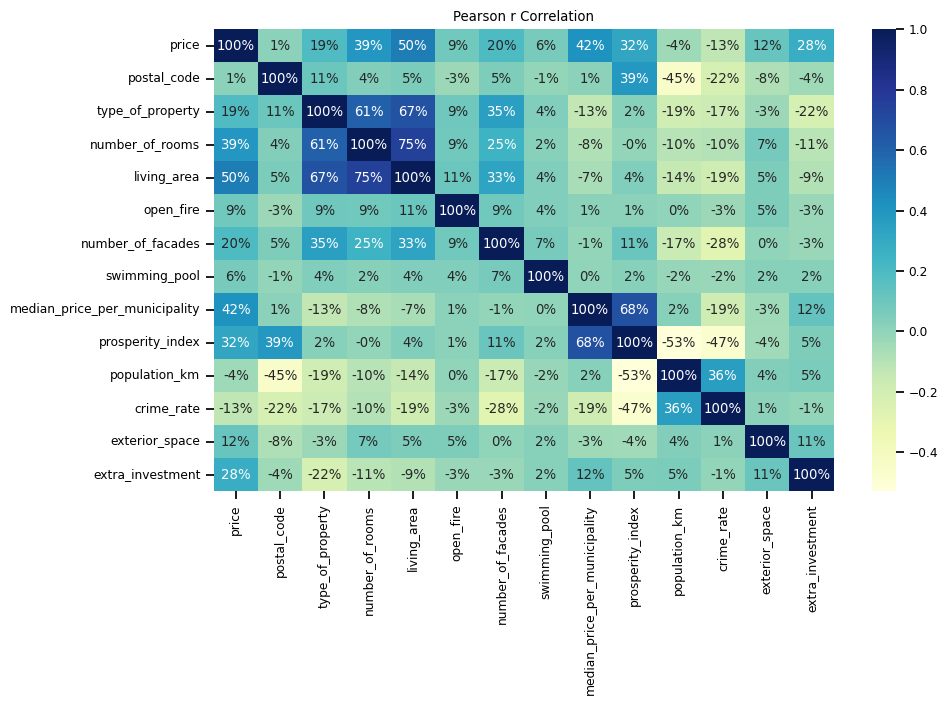

In [76]:
categorical_features = real_estate_data.select_dtypes(include = ["object"]).columns
numerical_features = real_estate_data.select_dtypes(exclude=["object"]).columns

pearson_corr_matrix = real_estate_data[numerical_features].corr()

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pearson_corr_matrix, annot=True, cmap="YlGnBu",fmt = '.0%')
plt.title("Pearson r Correlation")
plt.show()

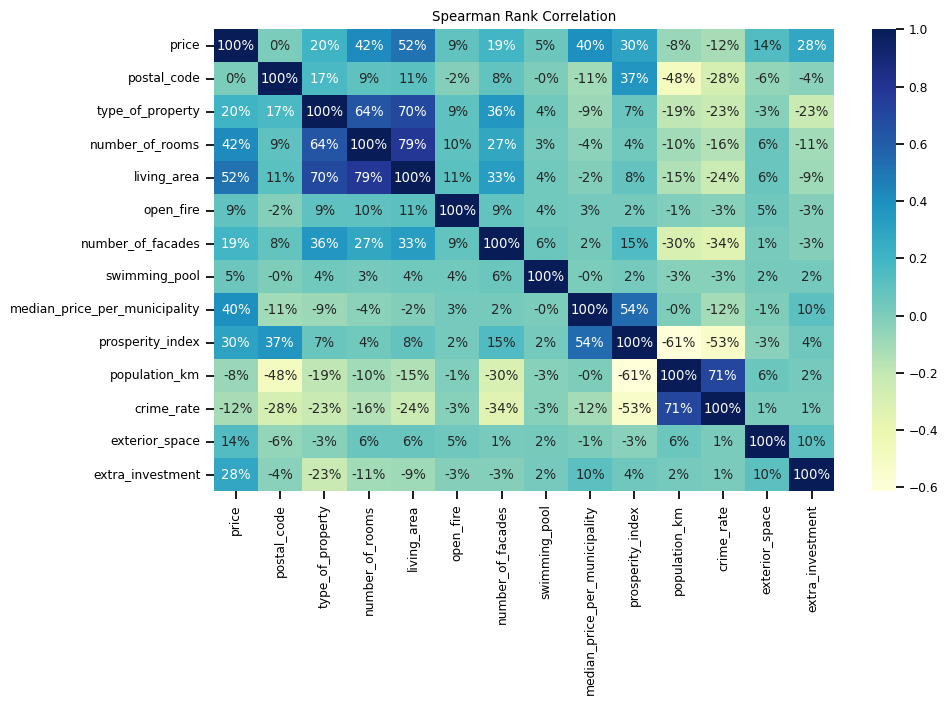

In [77]:
plt.figure(figsize=(10,6))
sns.heatmap(real_estate_data[numerical_features].corr(method='spearman'), annot=True, cmap="YlGnBu",fmt = '.0%')
plt.title("Spearman Rank Correlation")
plt.show()

In [78]:
# Calculate the correlation matrix for continuous columns
correlation_df = pd.DataFrame(real_estate_data[numerical_features].corr().round(2))
correlation_df


,price,postal_code,type_of_property,number_of_rooms,living_area,open_fire,number_of_facades,swimming_pool,median_price_per_municipality,prosperity_index,population_km,crime_rate,exterior_space,extra_investment
price,1.00,0.01,0.19,0.39,0.50,0.09,0.20,0.06,0.42,0.32,-0.04,-0.13,0.12,0.28
postal_code,0.01,1.00,0.11,0.04,0.05,-0.03,0.05,-0.01,0.01,0.39,-0.45,-0.22,-0.08,-0.04
type_of_property,0.19,0.11,1.00,0.61,0.67,0.09,0.35,0.04,-0.13,0.02,-0.19,-0.17,-0.03,-0.22
number_of_rooms,0.39,0.04,0.61,1.00,0.75,0.09,0.25,0.02,-0.08,-0.00,-0.10,-0.10,0.07,-0.11
living_area,0.50,0.05,0.67,0.75,1.00,0.11,0.33,0.04,-0.07,0.04,-0.14,-0.19,0.05,-0.09
open_fire,0.09,-0.03,0.09,0.09,0.11,1.00,0.09,0.04,0.01,0.01,0.00,-0.03,0.05,-0.03
number_of_facades,0.20,0.05,0.35,0.25,0.33,0.09,1.00,0.07,-0.01,0.11,-0.17,-0.28,0.00,-0.03
swimming_pool,0.06,-0.01,0.04,0.02,0.04,0.04,0.07,1.00,0.00,0.02,-0.02,-0.02,0.02,0.02
median_price_per_municipality,0.42,0.01,-0.13,-0.08,-0.07,0.01,-0.01,0.00,1.00,0.68,0.02,-0.19,-0.03,0.12
prosperity_index,0.32,0.39,0.02,-0.00,0.04,0.01,0.11,0.02,0.68,1.00,-0.53,-0.47,-0.04,0.05


Price is positively influenced by living_area, prosperity_index, number_of_rooms and it shows little to no correlation with population_km, postal_code, furnished, open_fire and accessible.

In [79]:
# Calculate VIF for each feature
vif = pd.DataFrame()
vif["Feature"] = real_estate_data[numerical_features].columns
vif["VIF"] = [variance_inflation_factor(real_estate_data[numerical_features].values, i) for i in range(real_estate_data[numerical_features].shape[1])]

vif

,Feature,VIF
0,price,14.163167
1,postal_code,6.008286
2,type_of_property,4.260369
3,number_of_rooms,15.682787
4,living_area,21.845464
5,open_fire,1.045394
6,number_of_facades,13.398038
7,swimming_pool,1.016551
8,median_price_per_municipality,35.524995
9,prosperity_index,82.762692


Columns 'postal_code','population_km' and 'crime_rate' has  the lower correaltion with price. 

'number_of_rooms', 'type_of_property' and 'number_of_facades' have high VIF and it overlaps with living_area. 

'state_of_the_building' overlaps with fully_equipped_kitchen. As 'state_of_the_building' has higer correaltions with price tht columns will be kept.   

In [80]:
columns_to_drop = ['open_fire', 'swimming_pool', 'type_of_property', 'postal_code', 'population_km', 'crime_rate', 'number_of_rooms', 'number_of_facades', 'exterior_space']
real_estate_data = real_estate_data.drop(columns=columns_to_drop)

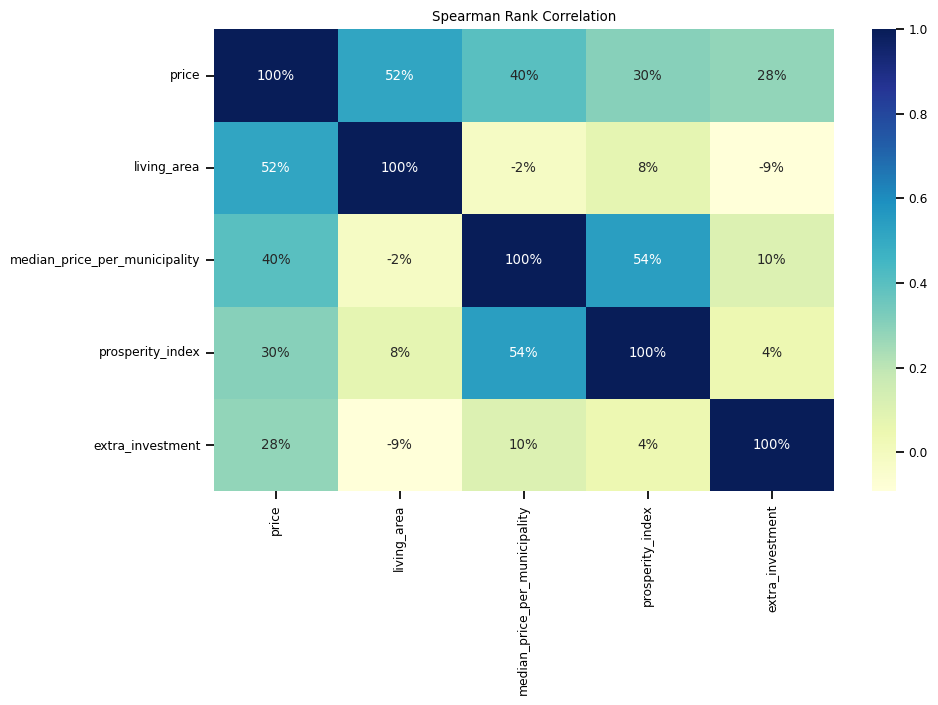

In [81]:
# Select all numerical columns from your dataset
numerical_columns = real_estate_data.select_dtypes(include=['number']).columns

# Create the heatmap with the numerical columns
plt.figure(figsize=(10, 6))
sns.heatmap(
    real_estate_data[numerical_columns].corr(method='spearman'), 
    annot=True, 
    cmap="YlGnBu", 
    fmt='.0%'
)
plt.title("Spearman Rank Correlation")
plt.show()

* Check linearity of residuals: Plot residuals vs fitted values to check patterns

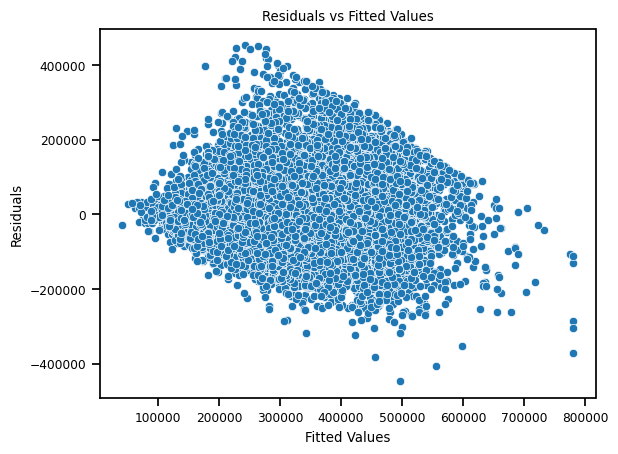

In [82]:
X1 = real_estate_data[numerical_columns].drop(columns=['price'])
y1 = real_estate_data['price']
X1 = sm.add_constant(X1)  
model = sm.OLS(y1, X1).fit()

fitted_values = model.fittedvalues
residuals = model.resid

sns.scatterplot(x=fitted_values, y=residuals)
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

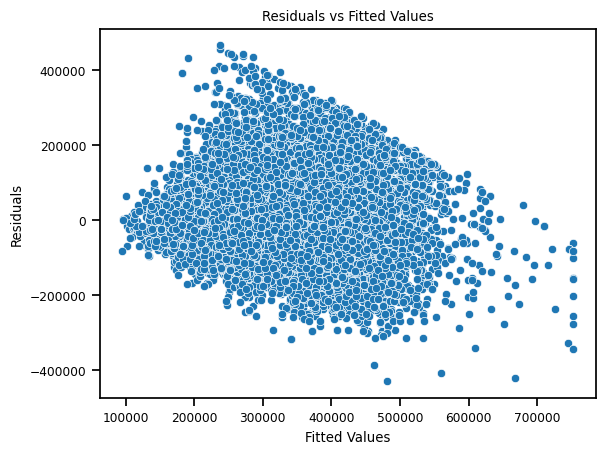

In [83]:
X = real_estate_data[['living_area', 'median_price_per_municipality']]
y = real_estate_data['price']
X = sm.add_constant(X)  
model = sm.OLS(y, X).fit()

fitted_values = model.fittedvalues
residuals_corr = model.resid

sns.scatterplot(x=fitted_values, y=residuals_corr)
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

In [84]:
# Durbin-Watson test
dw_statistic = durbin_watson(residuals_corr)
print(f'Durbin-Watson statistic: {dw_statistic}')

dw_statistic = durbin_watson(residuals)
print(f'Durbin-Watson statistic: {dw_statistic}')


Durbin-Watson statistic: 1.9909568757988678
Durbin-Watson statistic: 1.986833731953829


The Durbin-Watson is 1.96 (very close to 2) indicating that there is no significant autocorrelation in the residuals. 

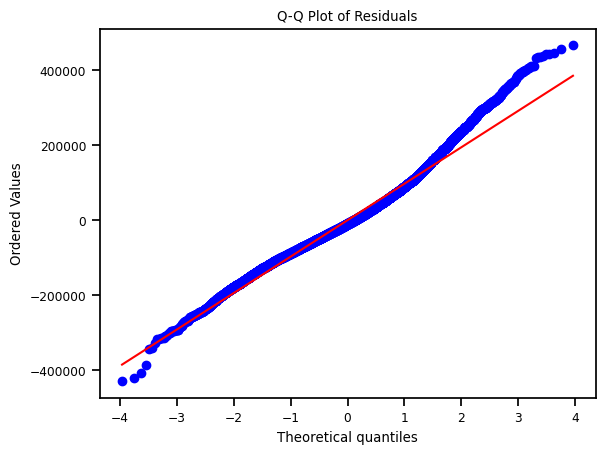

Shapiro-Wilk Test p-value: 2.4571280875801677e-50


/opt/anaconda3/envs/immo-eliza/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 19158.
  res = hypotest_fun_out(*samples, **kwds)


In [85]:
# Q-Q plot
stats.probplot(residuals_corr, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()

# Shapiro-Wilk test
from scipy.stats import shapiro
stat, p_value = shapiro(residuals)
print(f'Shapiro-Wilk Test p-value: {p_value}')


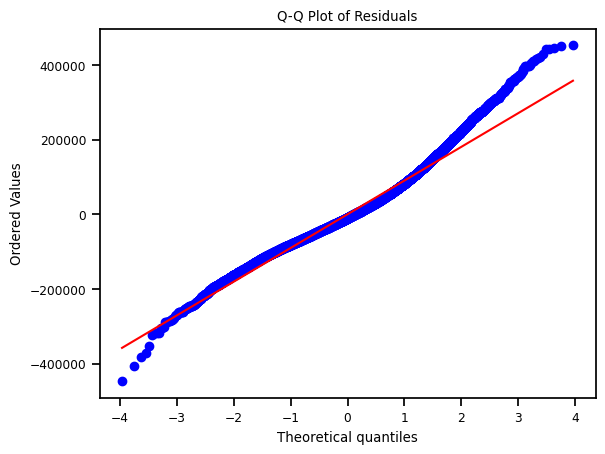

Shapiro-Wilk Test p-value: 2.4571280875801677e-50


In [86]:
# Q-Q plot
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()

# Shapiro-Wilk test
from scipy.stats import shapiro
stat, p_value = shapiro(residuals)
print(f'Shapiro-Wilk Test p-value: {p_value}')

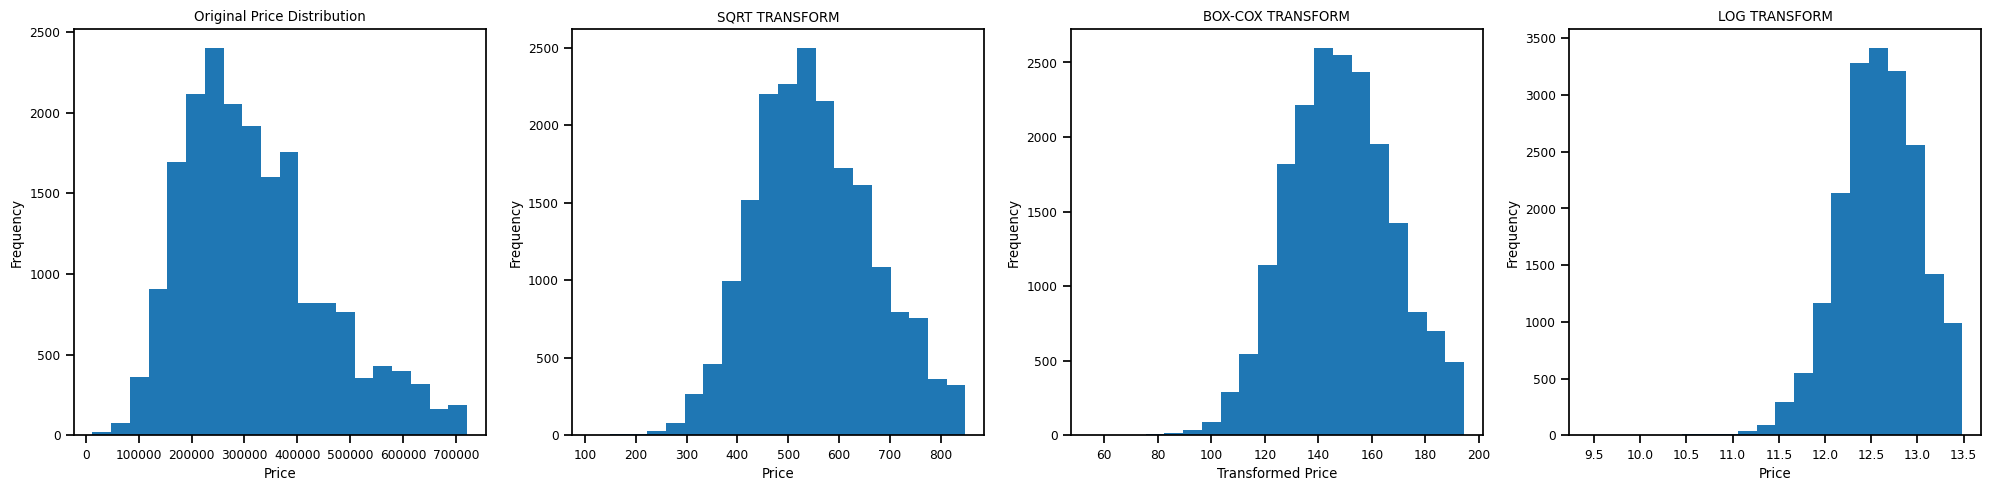

In [87]:
# Plot different types of transofmrations on Price

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Plot 1: Original Price Distribution
axes[0].hist(real_estate_data['price'], bins=20)
axes[0].set_title('Original Price Distribution')
axes[0].set_xlabel('Price')
axes[0].set_ylabel('Frequency')

# Plot 2: Square Root Transformation
axes[1].hist(np.sqrt(real_estate_data['price']), bins=20)
axes[1].set_title('SQRT TRANSFORM')
axes[1].set_xlabel('Price')
axes[1].set_ylabel('Frequency')

# Plot 3: Box-Cox Transformation with lambda = 0.6
transformed_boxcox, _ = stats.boxcox(real_estate_data['price'])  
axes[2].hist(transformed_boxcox, bins=20)
axes[2].set_title('BOX-COX TRANSFORM')
axes[2].set_xlabel('Transformed Price')
axes[2].set_ylabel('Frequency')

# Plot 4: Log Transformation
axes[3].hist(np.log(real_estate_data['price']), bins=20)
axes[3].set_title('LOG TRANSFORM')
axes[3].set_xlabel('Price')
axes[3].set_ylabel('Frequency')

# Show the plots
plt.tight_layout()
plt.show()


SQRT transformation seems to be best option to transform the data. 

In [88]:
real_estate_data = real_estate_data.drop_duplicates()
real_estate_data.shape

(18208, 5)

In [89]:
real_estate_data.head(10)

,price,living_area,median_price_per_municipality,prosperity_index,extra_investment
0,148000.0,149.0,180625.0,91.0,4
2,225000.0,61.0,225000.0,107.0,3
3,445000.0,105.0,405000.0,111.0,3
4,269000.0,72.0,285000.0,87.0,3
6,465000.0,93.0,243000.0,102.0,5
7,209000.0,68.0,243937.5,93.0,3
10,375000.0,116.0,285000.0,87.0,3
11,413400.0,132.0,271250.0,114.0,5
13,269000.0,85.0,285000.0,87.0,3
14,149000.0,123.0,214000.0,100.0,4


***

In [90]:
real_estate_data.columns

Index(['price', 'living_area', 'median_price_per_municipality',
       'prosperity_index', 'extra_investment'],
      dtype='object')

### Save dataframe

In [91]:
real_estate_data.to_csv(data_path / 'real_estate_belguim.csv', index=False)